In [1]:
from retrotide import structureDB, designPKS
import retrotide
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
%matplotlib inline
from collections import OrderedDict
from IPython.display import SVG
from copy import deepcopy
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

[18:07:55] product atom-mapping number 10 not found in reactants.
[18:07:55] product atom-mapping number 10 not found in reactants.


In [ ]:
KS_rxn = AllChem.ReactionFromSmarts(('[#8:4]=[#6:3](-[#8:5])-[#6@:2]-[#6:1].[#6:6](=[#8:7])-[#16:8]>>[#8:4]=[#6:3]=[#8:5].[#6@@:2](-[#6:1])-[#6:6]=[#8:7].[#16:8]'))
starter_unit = Chem.MolFromSmiles((starters_dict['mal'])) # malonly-CoA starter
extender_unit = Chem.MolFromSmiles(extenders_dict['mal']) # malonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

In [32]:
cyanohydrin_rxn = AllChem.ReactionFromSmarts(("[CX3!$(*[O,S,N])+0:1]=[O+0:2].[C+0H:3]#[N+0:4]>>[*:1]([*:3]#[*:4])[*:2]"))
acetonitrile = Chem.MolFromSmiles(('C#N'))
substrate = Chem.MolFromSmiles(('CCC(C(C)C(CC)=O)=O'))
products = cyanohydrin_rxn.RunReactants((substrate,acetonitrile))

In [33]:
products

((<rdkit.Chem.rdchem.Mol at 0x7fb06bb0f270>,),
 (<rdkit.Chem.rdchem.Mol at 0x7fb06bb0fa50>,))

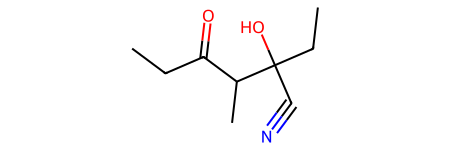

In [34]:
products[0][0]

In [35]:
Chem.MolToSmiles(products[0][0])

'CCC(=O)C(C)C(O)(C#N)CC'

In [19]:
r'C#N'.'CC(=O)CC(C)=O'>>'CC(=O)CC(C)(O)C#N'

SyntaxError: invalid syntax (4038714161.py, line 1)

#### Some RDKit helper functions

In [2]:
def get_atom_mappings(smiles):
    """
    Assigns unique atom map numbers to each atom in a molecule represented by SMILES.

    Parameters:
    - smiles (str): A SMILES string representing a molecule.

    Returns:
    - rdkit.Chem.Mol: A RDKit Mol object with "molAtomMapNumber" properties set for each atom.
    
    Example:
    >>> smiles = "CCO"
    >>> mol = get_atom_mappings(smiles)
    >>> Chem.MolToSmiles(mol)
    'C[CH2:1]O'
    
    Note:
    The function modifies the input molecule by setting the "molAtomMapNumber" property
    for each atom to its index in the molecule plus 1.
    """
    mol = Chem.MolFromSmiles(smiles)

    # Iterate over the atoms
    for i, atom in enumerate(mol.GetAtoms()):
        # For each atom, set the property "molAtomMapNumber" to a custom number
        # Say, the index of the atom in the molecule
        atom.SetProp("molAtomMapNumber", str(atom.GetIdx() + 1))

    return mol

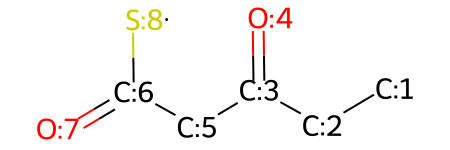

In [3]:
### Example usage
mol = get_atom_mappings('CCC(=O)CC(=O)[S]')
mol

In [4]:
def is_substructure_present(smiles_list,substructure):
    for idx,smiles in enumerate(smiles_list):
        m = Chem.MolFromSmiles(smiles)
        print("Structure {}: pattern found {}".format(idx+1,m.HasSubstructMatch(substructure)))

In [5]:
### Example usage
smiles_list = ['CC(=O)CC(=O)[S]']
substructure = Chem.MolFromSmarts('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]')
is_substructure_present(smiles_list,substructure)

Structure 1: pattern found True


In [6]:
def draw_substruct_match(mol, substructure, size=(400, 200)):
    """
    Draws the provided substructure match within the given molecule and returns the SVG representation.

    Parameters:
    - mol (rdkit.Chem.Mol): The RDKit Mol object representing the molecule.
    - substructure (rdkit.Chem.Mol): The RDKit Mol object representing the substructure to be highlighted.
    - size (tuple, optional): The size of the drawing in pixels. Default is (400, 200).

    Returns:
    - str: SVG representation of the molecule with the specified substructure highlighted.

    Example:
    >>> mol = Chem.MolFromSmiles("CCO")
    >>> substructure = Chem.MolFromSmarts("[CH2:1]")
    >>> svg_representation = draw_substruct_match(mol, substructure)
    >>> SVG(svg_representation)
    
    Note:
    The function creates a copy of the input molecule and substructure to avoid modifying the original objects.
    The returned SVG representation includes the highlighting of atoms in the specified substructure match.
    """
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])

    # highlightAtoms expects only one tuple, not tuple of tuples.
    # So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()

    return svg.replace('svg:', '')

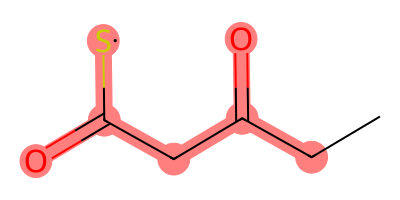

In [7]:
### Example usage
substructure = Chem.MolFromSmarts('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]')
mol = Chem.MolFromSmiles('CCC(=O)CC(=O)[S]')
SVG(draw_substruct_match(mol,substructure))

### Type I PKS starters and extenders

#### malonyl-CoA as a starter unit

Malonyl-CoA has 3 carbon atoms and the following structure but recall that in the loading module, the Ketosynthase-like `KSq` domain will decarboxylate malonyl-CoA such that only two carbon atoms are loaded. Read more about the `KSq` domain here: https://pubs.acs.org/doi/full/10.1021/acschembio.1c00856

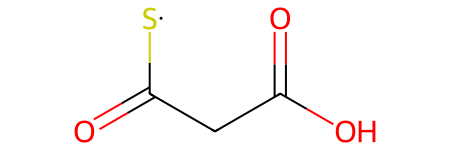

In [8]:
Chem.MolFromSmiles('O=C(O)CC(=O)[S]')

Thus, as the starter unit, we will write the SMILES of the decarboxylated malonyl-CoA as `CC(=O)[S]`

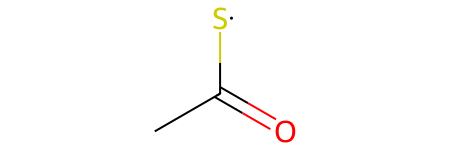

In [9]:
Chem.MolFromSmiles('CC(=O)[S]')

#### methylmalonyl-CoA as a starter unit

Similarly, even though methylmalonyl-CoA has four carbon atoms and the following structure (drawn without stereochemistry), it also undergoes decarboxylation with the `KSq` domain to load only three carbon atoms

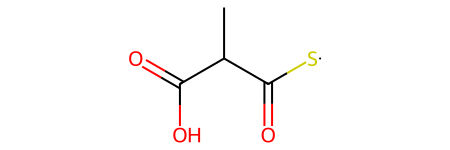

In [10]:
Chem.MolFromSmiles('CC(C(=O)O)C(=O)[S]')

Thus, as the starter unit, we will write the SMILES of the decarboxylated methylmalonyl-CoA as `CCC(=O)[S]`

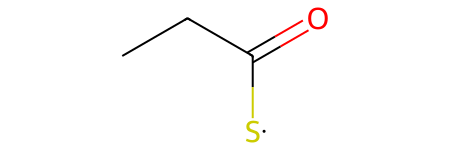

In [11]:
Chem.MolFromSmiles('CCC(=O)[S]')

#### Dictionary of various starter and extender units

In [12]:
starters_dict = {'mal':'CC(=O)[S]',
                 'mmal':'CCC(=O)[S]',
                 'allylmal': 'C=CCC(=O)[S]'}


extenders_dict = {'mal':'O=C(O)CC(=O)[S]',
                  'mmal':'C[C@@H](C(=O)O)C(=O)[S]',
                  'allylmal': 'C=CCC(C(=O)O)C(=O)[S]'}

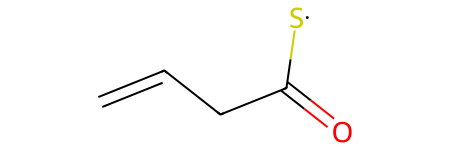

In [97]:
Chem.MolFromSmiles('C=CCC(=O)[S]')

#### malonyl-CoA as an extender unit

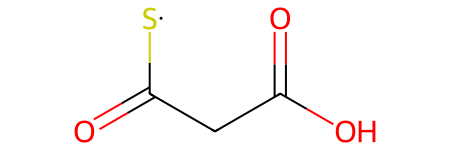

In [13]:
Chem.MolFromSmiles('O=C(O)CC(=O)[S]')

#### methylmalonyl-CoA as an extender unit

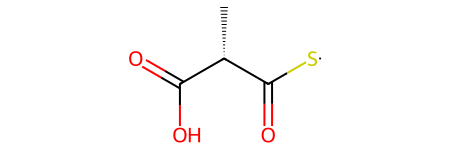

In [14]:
Chem.MolFromSmiles('C[C@@H](C(=O)O)C(=O)[S]')

### PKS operators

### Ketosynthases (KS)

#### Writing SMARTS operators with stereochemistry

Not sure what the Retrotide operator for KS is but could it be written as a decarboxylation first and then a addition?

First, let's extract the atom mappings of methylmalonyl-CoA

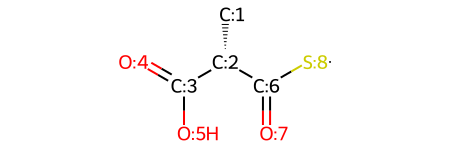

In [15]:
get_atom_mappings('C[C@@H](C(=O)O)C(=O)[S]')

Subsequently, let's try to represent stereochemistry with SMARTS. To indicate stereochemistry, use BOTH the `@` and the `-` operators in the SMARTS string

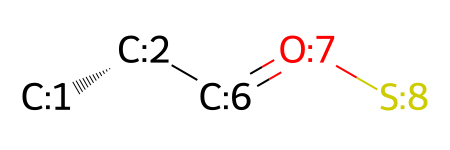

In [16]:
# one stereoisomer
Chem.MolFromSmarts('[#6@@:2](-[#6:1])-[#6:6]=[#8:7]-[S:8]')

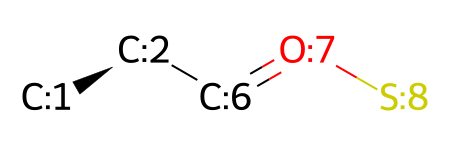

In [17]:
# the opposite stereoisomer/ enantiomer
Chem.MolFromSmarts('[#6@:2](-[#6:1])-[#6:6]=[#8:7]-[S:8]')

Without the `-` operator to the left of `[#6:1]`, the SMARTS string does NOT display stereochemistry

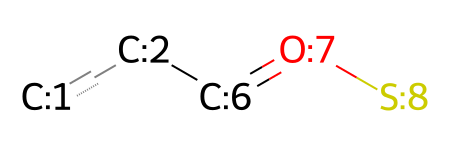

In [18]:
Chem.MolFromSmarts('[#6@:2]([#6:1])-[#6:6]=[#8:7]-[S:8]')

The same is true if the `@` operator within `[#6:2]` were absent even if there was `-` operator to the left of `[#6:1]`

Therefore, to indicate stereochemistry, we need BOTH `@` and `-` operators as observed in the following substructure:

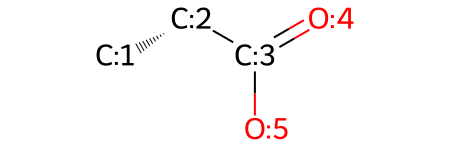

In [19]:
Chem.MolFromSmarts('[#8:4]=[#6:3](-[#8:5])-[#6@:2]-[#6:1]')

Let's confirm that there is indeed a substructure match between the SMARTS string that we have written out and the stereochemical SMILES string for methylmalonyl-CoA (`C[C@@H](C(=O)O)C(=O)[S]`)

In [20]:
substructure = Chem.MolFromSmarts('[#8:4]=[#6:3](-[#8:5])-[#6@:2]-[#6:1]')
smiles_list = ['C[C@@H](C(=O)O)C(=O)[S]']
is_substructure_present(smiles_list,substructure)

Structure 1: pattern found True


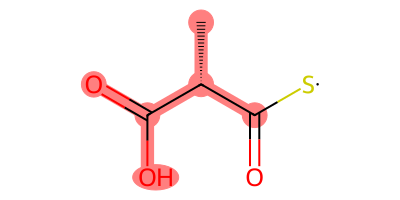

In [21]:
### Example usage
mol = Chem.MolFromSmiles('C[C@@H](C(=O)O)C(=O)[S]')
SVG(draw_substruct_match(mol,substructure))

#### Trying to run Ketosynthase reactions

In [22]:
KS_rxn = AllChem.ReactionFromSmarts(('[#8:4]=[#6:3](-[#8:5])-[#6@:2]-[#6:1].[#6:6](=[#8:7])-[#16:8]>>[#8:4]=[#6:3]=[#8:5].[#6@@:2](-[#6:1])-[#6:6]=[#8:7].[#16:8]'))

In [23]:
KS_rxn = AllChem.ReactionFromSmarts(('[#8:4]=[#6:3](-[#8:5])-[#6@:2]-[#6:1].[#6:6](=[#8:7])-[#16:8]>>[#8:4]=[#6:3]=[#8:5].[#6@@:2](-[#6:1])-[#6:6]=[#8:7].[#16:8]'))
starter_unit = Chem.MolFromSmiles((starters_dict['mal'])) # malonly-CoA starter
extender_unit = Chem.MolFromSmiles(extenders_dict['mal']) # malonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

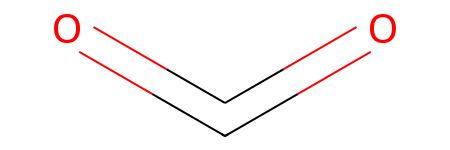

In [24]:
products[0][0]

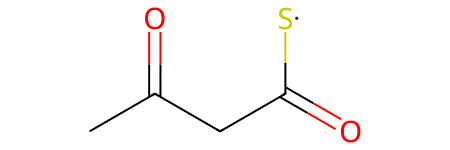

In [25]:
products[0][1]

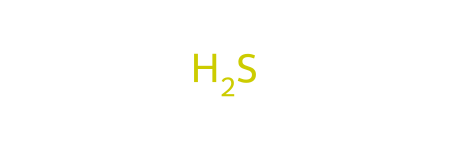

In [26]:
products[0][2]

**After trying a couple of iterations, a possible SMARTS template representing a kethosynthase reaction with stereoinversion is: `[#8:4]=[#6:3](-[#8:5])-[#6@:2]-[#6:1].[#6:6](=[#8:7])-[#16:8]>>[#8:4]=[#6:3]=[#8:5].[#6@@:2](-[#6:1])-[#6:6]=[#8:7].[#16:8]`**. Here there are two periods on the LHS of the `>>` sign becasue we are specifying two species. The first is the extender unit while the second is the either starter unit or the final product from the previous module. Subsequently, there are three periods on the RHS of the `>>` sign because we are specifying three species - a decarboxylated product, a CO2, and a H2S group.

#### Example 1: A 2 module type I PKS with the first (loading) module being KSq-AT-ACP and the second being KS-AT-ACP. The starter unit is a malonyl-CoA and extender unit is also a malonyl-CoA

In [27]:
starter_unit = Chem.MolFromSmiles((starters_dict['mal'])) # malonly-CoA starter
extender_unit = Chem.MolFromSmiles(extenders_dict['mal']) # malonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        final_product = product

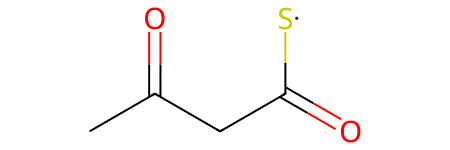

In [28]:
final_product

This is indeed the product we would expect after a loading module starting with malonyl-CoA and a single non-loading module that tacks on malonyl-CoA onto the growing carbon chain.

#### Example 2: A 3 module type I PKS with all 3 modules being KS-AT-ACP. The starter unit is a malonyl-CoA and the two extender units are also malonyl-CoA

In [29]:
# Final product after the first non-loading module
starter_unit = Chem.MolFromSmiles((starters_dict['mal'])) # malonly-CoA starter
extender_unit = Chem.MolFromSmiles(extenders_dict['mal']) # malonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        final_product = product
        
final_product_smiles = Chem.MolToSmiles(final_product)

# Final product after the second non-loading module (pass in the final product from before as a starter)
starter_unit = Chem.MolFromSmiles((final_product_smiles)) # starter unit is the final product from prior module
extender_unit = Chem.MolFromSmiles(extenders_dict['mal']) # malonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        final_product = product

final_product_smiles = Chem.MolToSmiles(final_product)

In [30]:
final_product_smiles

'CC(=O)CC(=O)CC(=O)[S]'

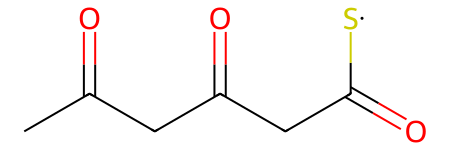

In [31]:
Chem.MolFromSmiles(final_product_smiles)

This is indeed the product that we would expect after a loading module starting with malonyl-CoA and two non-loading modules that also acept malonlyl-CoA extenders

#### Example 3: A 2 module type I PKS with all 2 modules being KS-AT-ACP. Here, let's have both the starter and extender units be methylmalonyl-CoA this time

In [32]:
starter_unit = Chem.MolFromSmiles((starters_dict['mmal'])) # methylmalonly-CoA starter
extender_unit = Chem.MolFromSmiles(extenders_dict['mmal']) # methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        final_product = product

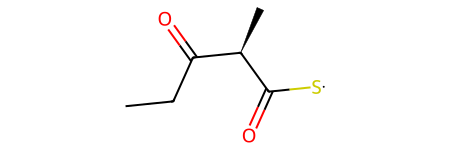

In [33]:
final_product

The first two carbon atoms closest to the sulfur atom come from the methylmalonyl-CoA extender unit. This extender unit also undergoes stereoinversion which changes the methyl group's stereochemistry from being in the "dashed" configuration to being in the "solid wedge" configuration. The three carbon atoms on the other end of the sulfur atom come from the loading of the methylmalonyl-CoA starter unit, which undergoes a decarboxlyation via the KSq domain in the loading module. So this product still seems to be what we would expect?

***Curiously, when I try to convert the `final_product` back to a smiles string and then from a smiles string back to a mol object, I lose stereochemistry information. Any thoughts why this happens and how we can prevent it?***

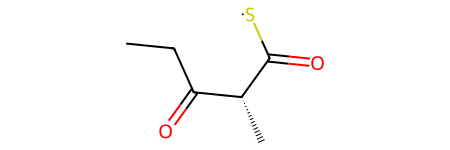

In [34]:
Chem.MolFromSmiles(Chem.MolToSmiles(final_product))

#### Example 4: A 3 module type I PKS with all 3 modules being KS-AT-ACP. Here, let's have the starting unit being methylmalonyl-CoA and both extender units being methylmalonyl-CoA as well

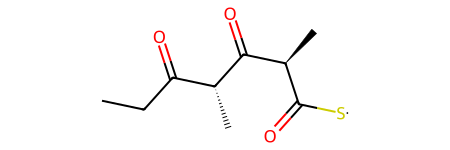

In [35]:
starter_unit = Chem.MolFromSmiles((starters_dict['mmal'])) # methylmalonly-CoA starter
extender_unit = Chem.MolFromSmiles(extenders_dict['mmal']) # methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        final_product = product
        
# Final product after the second non-loading module (pass in the final product from before as a starter)
starter_unit = final_product
extender_unit = Chem.MolFromSmiles(extenders_dict['mmal']) # methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        final_product = product

final_product

I think this product is what we would expect? The solid wedge present after the first two modules in example 3 would have its stereochemistry flipped and would become a dashed wedge? Meanwhile the dashed wedge from the latest methylmalonyl-CoA extender unit would be flipped to beocome a solid wedge?

### Ketoreductases (KR)

In [36]:
KR_type = 'B1'

In [37]:
### Type A1
KR_type_A1 = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C@:2]([O:3])[C@:4]'
                                           '[C:5](=[O:6])[S:7]'))

KR_type_A1_y = AllChem.ReactionFromSmarts(('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]>>[C:1]-[C@:2]([O:3])-[C@:4]-[C:5](=[O:6])-[S:7]'))

### Type A2
KR_type_A2 = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C@:2]([O:3])[C@@:4]'
                                           '[C:5](=[O:6])[S:7]'))

KR_type_A2_y = AllChem.ReactionFromSmarts(('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])[S:7]>>[C:1]-[C@:2]([O:3])-[C@@:4]-[C:5](=[O:6])-[S:7]'))

### Type A
KR_type_A = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C@:2]([O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]'))

KR_type_A_y = AllChem.ReactionFromSmarts(('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]>>[#0:1]-[C@:2]([O:3])-[C:4]-[C:5](=[O:6])[S:7]'))

### Type B1
KR_type_B1 = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                       '[C:5](=[O:6])[S:7]>>'
                                       '[#0:1][C@@:2]([O:3])[C@:4]'
                                       '[C:5](=[O:6])[S:7]'))

KR_type_B1_y = AllChem.ReactionFromSmarts(('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]>>[#0:1][C@@:2]([O:3])[C@:4][C:5](=[O:6])[S:7]'))

### Type B2
KR_type_B2 = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C@@:2]([O:3])[C@@:4]'
                                           '[C:5](=[O:6])[S:7]'))

KR_type_B2_y = AllChem.ReactionFromSmarts(('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]>>[#0:1]-[C@@:2]([O:3])-[C@@:4]-[C:5](=[O:6])[S:7]'))

### Type B
KR_type_B = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C@@:2]([O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]'))

KR_type_B_y = AllChem.ReactionFromSmarts(('[C:1]-[C:2](=[O:3])-[C:4][C:5](=[O:6])-[S:7]>>[C:1]-[C@@:2]([O:3])-[C:4]-[C:5](=[O:6])-[S:7]'))

### Type C1
KR_type_C1 = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C:2](=[O:3])[C@:4]'
                                           '[C:5](=[O:6])[S:7]'))

KR_type_C1_y = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C:2](=[O:3])[C@:4]'
                                           '[C:5](=[O:6])[S:7]'))

### Type C2
KR_type_C2 = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C:2](=[O:3])[C@@:4]'
                                           '[C:5](=[O:6])[S:7]'))
KR_type_C2_y = AllChem.ReactionFromSmarts(('[#0:1][C:2](=[O:3])[C:4]'
                                           '[C:5](=[O:6])[S:7]>>'
                                           '[#0:1][C:2](=[O:3])[C@@:4]'
                                           '[C:5](=[O:6])[S:7]'))

### Dehydratases (DH)

In [66]:
dh_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5](-[#8:6])-[#6:7]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5]=[#6:7]')

### Enoylreductases (ER)

In [40]:
# Enoylreductase (ER) Domain - taken directly from ClusterCAD
er_rxn = AllChem.ReactionFromSmarts('[CH2]=[CH]>>[CH2][CH2]')

### Methyltransferases (MT) - C methyltransferase and O methyltransferase operators from ClusterCAD

In [41]:
cMT_rxn = AllChem.ReactionFromSmarts('[C:1][C:2](=[O:3])[S:4]>>[C:1](C)[C:2](=[O:3])[S:4]')

In [42]:
# Methyltransferase (MT) Domain
mt_reaction = AllChem.ReactionFromSmarts('[CH3:1]>>[*:1][CH3]')

### Different types of Thioesterases (TE)

#### 1. Macrolactone froming TE (from ClusterCAD) - don't run

In [43]:
# if len(chain.GetSubstructMatches(Chem.MolFromSmiles('CC(=O)CC(=O)S'))) == 1:
    
#     macrolactonization_TE = AllChem.ReactionFromSmarts(('[C:2](=[O:3])[C:4][C:5](=[O:6])[S:7]>>'
#                                                   '[C:2]([O:3]C)=[C:4][C:5](=[O:6])[S:7]'))
    
# if len(chain.GetSubstructMatches(Chem.MolFromSmiles('CC(O)CC(=O)S'))) == 1:
    
#     macrolactonization_TE = AllChem.ReactionFromSmarts(('[C:2]([O:3])[C:4][C:5](=[O:6])[S:7]>>'
#                                                   '[C:2]([O:3]C)[C:4][C:5](=[O:6])[S:7]'))

#### 2. Carboxylic acid forming TE (from ClusterCAD)

In [44]:
carboxylic_acid_TE = AllChem.ReactionFromSmarts('[C:1](=[O:2])[S:3]>>[C:1](=[O:2])[O].[S:3]')

In [45]:
# Yash written TE reaction for cyclization
# the position of the 1 indicates where the ring begins and ends
macrolactonization_TE = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5]-[#6:6]-[#6:7]-[#8:8]>>[#16:1].[#6:2]1(=[#8:3])-[#6:4]-[#6:5]-[#6:6]-[#6:7]-[#8:8]1')

#### 3. Terminal alkene forming TE (by Yash, in conjunction with a sulfonyltransferase)

In [46]:
substructure = Chem.MolFromSmarts('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]')
smiles_list = ['C=CCC(=O)[C@@H](C)C(=O)[S]']
is_substructure_present(smiles_list,substructure)

Structure 1: pattern found True


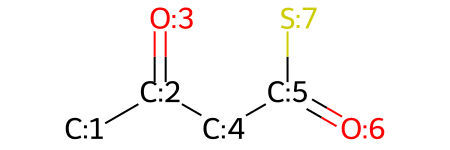

In [47]:
Chem.MolFromSmarts('[C:1]-[C:2](=[O:3])-[C:4]-[C:5](=[O:6])-[S:7]')

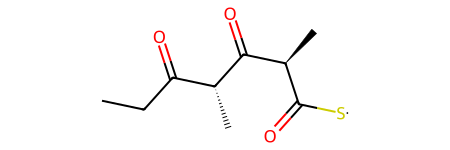

In [48]:
final_product

### Discodermolide

#### C1-C8 subunit synthesis

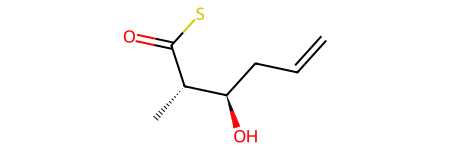

In [49]:
starter_unit = Chem.MolFromSmiles((starters_dict['allylmal'])) # allylmalonyl-CoA starter
extender_unit = Chem.MolFromSmiles((extenders_dict['mmal'])) # methylmalonyl-CoA extender

### Module 1

# KS in the first module takes allylmalonyl-CoA from the loading module and adds it to a methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# KR in the first module reduces the carbonyl group that is farther away from the sulfur bond
chain = KR_type_B2_y.RunReactants((chain,))[0][0]

# Even though the stereochemistry of the product may be displayed differently from what is displayed on ClusterCAD,
# I confirmed that both molecules have the same absolute stereochemistry
chain

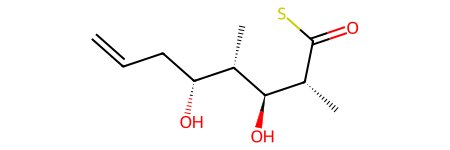

In [50]:
### Module 2

# KS in the second module takes the chain from the first module and adds it to a methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,chain))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# KR in the second module reduces the carbonyl group that is farther away from the sulfur bond
chain = KR_type_A1_y.RunReactants((chain,))[0][0]

# Even though the stereochemistry of the product may be displayed differently from what is displayed on ClusterCAD,
# I confirmed that both molecules have the same absolute stereochemistry
chain

In [51]:
### Module 2 (Yes, this is still module 2)

# final termination and off-loading reaction
products = macrolactonization_TE.RunReactants((chain,))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'S':
        final_product = product

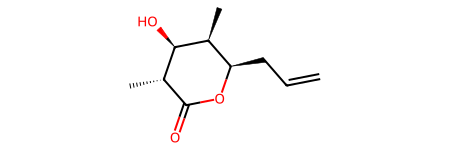

In [52]:
final_product

In [53]:
Chem.MolToSmiles(final_product)

'C=CC[C@H]1OC(=O)[C@H](C)[C@@H](O)[C@H]1C'

#### C19-C24 subunit

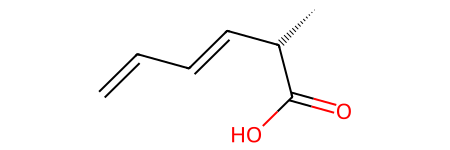

In [138]:
starter_unit = Chem.MolFromSmiles((starters_dict['allylmal'])) # allylmalonyl-CoA starter
extender_unit = Chem.MolFromSmiles((extenders_dict['mal'])) # malonyl-CoA extender
dh_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5](-[#8:6])-[#6:7]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5]=[#6:7]')

### Module 1

# KS in the first module takes allylmalonyl-CoA from the loading module and adds it to a methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# KR in the first module reduces the carbonyl group that is farther away from the sulfur bond
chain = KR_type_B2_y.RunReactants((chain,))[0][0]

# DH in the first module removes an alcohol group and a hydrogen atom to induce a double bond and release water
products = dh_rxn.RunReactants((chain,))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# MT in the first module adds a methyl group
cMT_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6@@:5]')
products = cMT_rxn.RunReactants((chain,))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# Carboxylic acid forming 
carboxylic_acid_TE.RunReactants((chain,))[0][0]

#### C9-C18 subunit

In [139]:
starter_unit = Chem.MolFromSmiles((starters_dict['allylmal'])) # allylmalonyl-CoA starter
extender_unit = Chem.MolFromSmiles((extenders_dict['mal'])) # malonyl-CoA extender
dh_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5](-[#8:6])-[#6:7]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5]=[#6:7]')

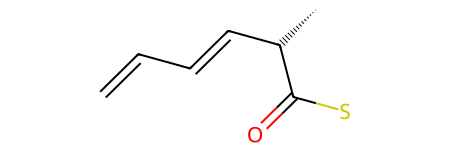

In [140]:
### Module 1

# KS in the first module takes allylmalonyl-CoA from the loading module and adds it to a methylmalonyl-CoA extender
products = KS_rxn.RunReactants((extender_unit,starter_unit))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# KR in the first module reduces the carbonyl group that is farther away from the sulfur bond
chain = KR_type_B2_y.RunReactants((chain,))[0][0]

# DH in the first module removes an alcohol group and a hydrogen atom to induce a double bond and release water
products = dh_rxn.RunReactants((chain,))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

# MT in the first module adds a methyl group
cMT_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6@@:5]')
products = cMT_rxn.RunReactants((chain,))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product
        
chain

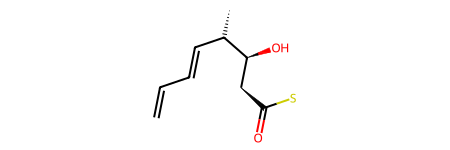

In [141]:
### Module 2
products = KS_rxn.RunReactants((extender_unit,chain))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product
        
# KR in the second module reduces the carbonyl group that is farther away from the sulfur bond
chain = KR_type_B2_y.RunReactants((chain,))[0][0]
chain

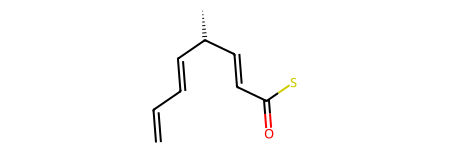

In [142]:
dh_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6:5](-[#8:6])-[#6:7]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]=[#6:5]-[#6:7]')
# DH in the second module removes an alcohol group and a hydrogen atom to induce a double bond and release water
products = dh_rxn.RunReactants((chain,))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product
        
chain

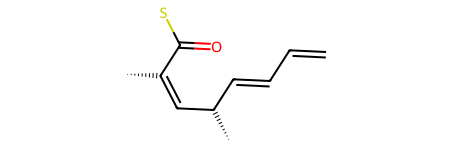

In [143]:
# MT in the second module adds a methyl group
cMT_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6@@:5]')
products = cMT_rxn.RunReactants((chain,))
    
for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product
        
chain

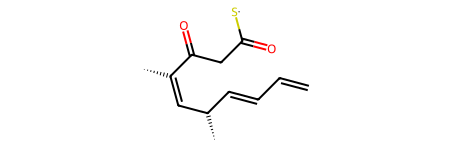

In [144]:
### Module 3
products = KS_rxn.RunReactants((extender_unit,chain))

for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product

chain

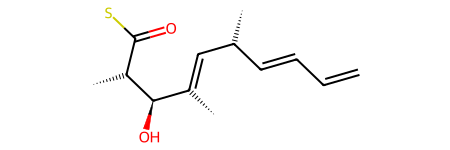

In [145]:
# KR in the third module reduces the carbonyl group that is farther away from the sulfur bond
chain = KR_type_B2_y.RunReactants((chain,))[0][0]

# MT in the third module adds a methyl group
cMT_rxn = AllChem.ReactionFromSmarts('[#16:1]-[#6:2](=[#8:3])-[#6:4]>>[#16:1]-[#6:2](=[#8:3])-[#6:4]-[#6@@:5]')
products = cMT_rxn.RunReactants((chain,))
    
for product in products[0]:
    if Chem.MolToSmiles(product) != 'O=C=O' and Chem.MolToSmiles(product) != 'S':
        chain = product
        
chain

### Retrotide points

#### 1. SMILES string for mmal

It looks like the SMILES string for methylmalonyl-CoA (mmal) in `retrotide/data/starters.smi` (github) is `CC(=O)[S]` but would mmal load 3 carbons so should this SMILES be: `CCC(=O)[S]` instead?

#### For NRPSs the A, C, Ox, R,  E (switch L to D amino acids), N methyltransferase, F (formylation domain), and AOX (A domain with a monooxygenase), R (reductive release domain that can stand in place of the TE) but for NRPSs is already present in ClusterCAD

In [ ]:
Chem.MolFromSmiles('CC(=O)CC(=O)S')